## CIFAR10 с MobileNet V2

In [1]:
import copy

from typing import Dict, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from sklearn.metrics import confusion_matrix
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets as D, models, transforms as T
from tqdm.notebook import tqdm

### Загрузка данных
#### Предобработка данных заключается в первоначальном изменении исходного изображения 32 х 32 до 224 х 224, так как это минимальные небходимый размер для сети MobileNetV2 из хаба pytorch, преобразовании их к тензору pytorch-а и приведению мат ожидания и дисперсии каждого канала изображения к следующим значенениям
#### Для обучающего датасета также будут использоваться аугментации:
1. ColorJitter
2. RandomEqualize
3. RandomHorizontalFlip и RandomVerticalFlip


In [2]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

transforms = {
    'train': T.Compose([
        T.Resize(224),
        T.ColorJitter(brightness=.5, hue=.3),
        T.RandomEqualize(),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD),
    ]),
    'valid': T.Compose([
        T.Resize(224),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD),
    ]),
}

batch_sizes = {'train': 224, 'valid': 480}

datasets = {
    'train': D.CIFAR10(root='./data', train=True, download=True, transform=transforms['train']),
    'valid': D.CIFAR10(root='./data', train=False, download=True, transform=transforms['valid']),
    'train_with_valid_transform': D.CIFAR10(root='./data', train=True, download=False, transform=transforms['valid']),
}

loaders = {
    'train': DataLoader(datasets['train'], batch_size=batch_sizes['train'], shuffle=True, num_workers=2),
    'valid': DataLoader(datasets['valid'], batch_size=batch_sizes['valid'], shuffle=False, num_workers=2),
    'train_with_valid_transform': DataLoader(datasets['train_with_valid_transform'], batch_size=batch_sizes['valid'], shuffle=False, num_workers=2),
}

Files already downloaded and verified
Files already downloaded and verified


### Функция обучения нейросети
В функции осуществляется обучение и валидация.

Входные параметры:
1. Количество эпох;
2. Модель;
3. Оптимизатор;
4. Функция потерь;
5. Лоадер;
6. Девайс;
7. Скэжулер;
8. Число шагов с аккамуляцией.

In [3]:
def train(
    num_epochs: int,
    model: nn.Module,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    loader: DataLoader,
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    scheduler = None,
    accumulation: Optional[int] = 1,
    early_stop_epoch_count: int = 2
) -> nn.Module:
    model = model.to(device)
    min_eval_loss = float('inf')
    stop_count = 0
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(
            model=model, optimizer=optimizer, criterion=criterion, loader=loader['train'],
            device=device, scheduler=scheduler, accumulation=accumulation
        )
        eval_loss, eval_acc = valid_epoch(
            model=model, criterion=criterion, loader=loader['valid'], device=device
        )
        if eval_loss < min_eval_loss and train_loss > eval_loss:
            best_model_wts = copy.deepcopy(model.state_dict())
            min_eval_loss = eval_loss
            stop_count = 0
        if train_loss < eval_loss:
            stop_count += 1

        print(f'Epoch: {epoch + 1:>2}/{num_epochs}'
        f'\tTrain loss: {train_loss:<8.4f} accuracy: {train_acc:<5.3f}'
        f'\tEval loss: {eval_loss:<8.4f} accuracy: {eval_acc:<5.3f}'
        )
        
        if stop_count >= early_stop_epoch_count:
            break

    print(f'Best eval loss: {min_eval_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def train_epoch(
    model: nn.Module,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    loader: Dict[str, DataLoader],
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    scheduler = None,
    accumulation: Optional[int] = 1,
) -> Tuple[float, float]:
    model = model.train().to(device)
    total_loss, right_answers, num_examples = 0, 0, 0
    len_dataloader = len(loader)

    for i, (imgs, labels) in tqdm(enumerate(loader, 1), leave=False, total=len_dataloader):
        imgs, labels = imgs.to(device), labels.to(device)

        logits = model(imgs)

        loss = criterion(logits, labels)
        loss.backward()
    
        if not i % accumulation or i == len_dataloader:
            optimizer.step()
            optimizer.zero_grad()
            if scheduler is not None:
                scheduler.step()
    
        total_loss += loss.item()

        right_answers += (torch.argmax(logits, dim=1) == labels).sum()
        num_examples += labels.size(0)

    return total_loss / len_dataloader, right_answers / num_examples

@torch.no_grad()
def valid_epoch(
    model: nn.Module,
    criterion: nn.Module,
    loader: DataLoader,
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
) -> Tuple[float, float]:
    model = model.eval().to(device)
    total_loss, right_answers, num_examples = 0, 0, 0
    len_dataloader = len(loader)

    for imgs, labels in tqdm(loader, leave=False, total=len_dataloader):
        imgs, labels = imgs.to(device), labels.to(device)

        logits = model(imgs)

        loss = criterion(logits, labels)
        
        total_loss += loss.item()

        right_answers += (torch.argmax(logits, dim=1) == labels).sum()
        num_examples += labels.size(0)

    return total_loss / len_dataloader, right_answers / num_examples

### Модель

Для обучения была взята MobileNetV2.

Изменена последняя часть сети - классификатор. Также были заморожены первые слои метки.

In [4]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1280, out_features=128),
    nn.LeakyReLU(0.05),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=128, out_features=10),
)
def freeze(model: nn.Module, last_freeze_layer: int) -> None:
    model_layers = list(model.parameters())
    for x in model_layers[:last_freeze_layer]:
        x.requires_grad = False
    for x in model_layers[freeze_layer:]:
        x.requires_grad = True

freeze_layer = 10
freeze(model, freeze_layer)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


### Параметры обучения

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.AdamW(list(model.parameters())[freeze_layer:], lr=3e-4)
criterion = nn.CrossEntropyLoss()
accumulation = 2
num_epochs = 15

In [6]:
best_model = train(num_epochs, model, optimizer, criterion, loaders, device, accumulation=accumulation)
torch.save(best_model.state_dict(), './mobilenetV2.pth')

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  1/15	Train loss: 0.8376   accuracy: 0.708	Eval loss: 0.4032   accuracy: 0.858


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  2/15	Train loss: 0.4512   accuracy: 0.845	Eval loss: 0.3245   accuracy: 0.888


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  3/15	Train loss: 0.3649   accuracy: 0.874	Eval loss: 0.2998   accuracy: 0.898


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  4/15	Train loss: 0.3121   accuracy: 0.893	Eval loss: 0.2829   accuracy: 0.901


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  5/15	Train loss: 0.2802   accuracy: 0.903	Eval loss: 0.2434   accuracy: 0.914


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  6/15	Train loss: 0.2438   accuracy: 0.917	Eval loss: 0.2405   accuracy: 0.919


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  7/15	Train loss: 0.2212   accuracy: 0.923	Eval loss: 0.2578   accuracy: 0.912


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  8/15	Train loss: 0.2023   accuracy: 0.930	Eval loss: 0.2344   accuracy: 0.921
Best eval loss: 0.240478


### Построение матрицы классификации на валидационном датасете

In [7]:
@torch.no_grad()
def compute_confusion_matrix(model, loader) -> Tuple[np.ndarray, float]:
    model = model.to(device)
    conf_matrix = np.zeros((10, 10))
    count, right_answers = 0, 0
    for inputs, labels in tqdm(loader, leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        logits = model(inputs)

        preds = torch.argmax(logits, dim=1)
        conf_matrix += confusion_matrix(
            labels.cpu().numpy(), preds.cpu().numpy()
        )
        count += inputs.size(0)
        right_answers += (preds == labels).sum()
    return conf_matrix, right_answers / count

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def plot_confusion_matrix(confusion_matrix: np.ndarray) -> None:
    plt.figure(figsize = (10,10))
    sns.heatmap(confusion_matrix, annot=True)
    plt.show()

def evaluation(model: nn.Module, loader: Dict[str, DataLoader]) -> None:
    model.eval()
    confusion_data, accuracy = compute_confusion_matrix(model, loaders['train_with_valid_transform'])
    conf_matrix = pd.DataFrame(confusion_data, index=classes, columns=classes)
    print(f'Accuracy on train is {accuracy}')
    plot_confusion_matrix(conf_matrix)
    confusion_data, accuracy = compute_confusion_matrix(model, loaders['valid'])
    conf_matrix = pd.DataFrame(confusion_data, index=classes, columns=classes)
    print(f'Accuracy on valid is {accuracy}')
    plot_confusion_matrix(conf_matrix)

  0%|          | 0/105 [00:00<?, ?it/s]

Accuracy on train is 0.9505399465560913


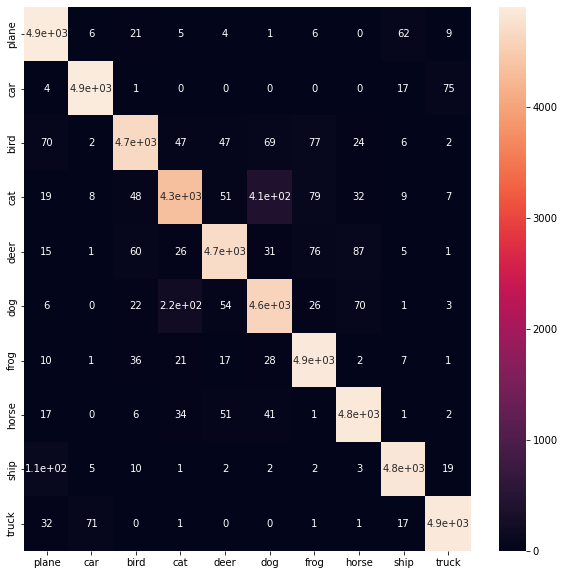

  0%|          | 0/21 [00:00<?, ?it/s]

Accuracy on valid is 0.9185999631881714


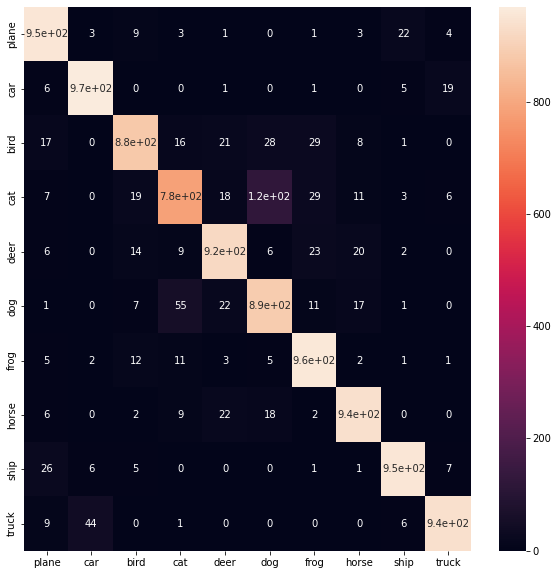

In [8]:
evaluation(best_model, loaders)

### Второй была выбрана новая MobileNetV3 **small**

In [9]:
model = models.mobilenet_v3_small(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=576, out_features=128),
    nn.LeakyReLU(0.05),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=128, out_features=10),
)
freeze(model, freeze_layer)
optimizer = optim.AdamW(list(model.parameters())[freeze_layer:], lr=3e-4)

In [10]:
best_model = train(num_epochs, model, optimizer, criterion, loaders, device, accumulation=accumulation)
torch.save(best_model.state_dict(), './mobilenetV3_small.pth')

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  1/15	Train loss: 1.1057   accuracy: 0.623	Eval loss: 0.6458   accuracy: 0.765


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  2/15	Train loss: 0.5278   accuracy: 0.817	Eval loss: 0.4065   accuracy: 0.861


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  3/15	Train loss: 0.4149   accuracy: 0.858	Eval loss: 0.3044   accuracy: 0.895


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  4/15	Train loss: 0.3560   accuracy: 0.877	Eval loss: 0.2620   accuracy: 0.907


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  5/15	Train loss: 0.3115   accuracy: 0.894	Eval loss: 0.2665   accuracy: 0.908


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  6/15	Train loss: 0.2861   accuracy: 0.901	Eval loss: 0.2466   accuracy: 0.914


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  7/15	Train loss: 0.2540   accuracy: 0.913	Eval loss: 0.2393   accuracy: 0.917


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  8/15	Train loss: 0.2345   accuracy: 0.920	Eval loss: 0.2316   accuracy: 0.919


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  9/15	Train loss: 0.2176   accuracy: 0.924	Eval loss: 0.2313   accuracy: 0.921


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 10/15	Train loss: 0.2021   accuracy: 0.931	Eval loss: 0.2232   accuracy: 0.925
Best eval loss: 0.231588


  0%|          | 0/105 [00:00<?, ?it/s]

Accuracy on train is 0.9521399736404419


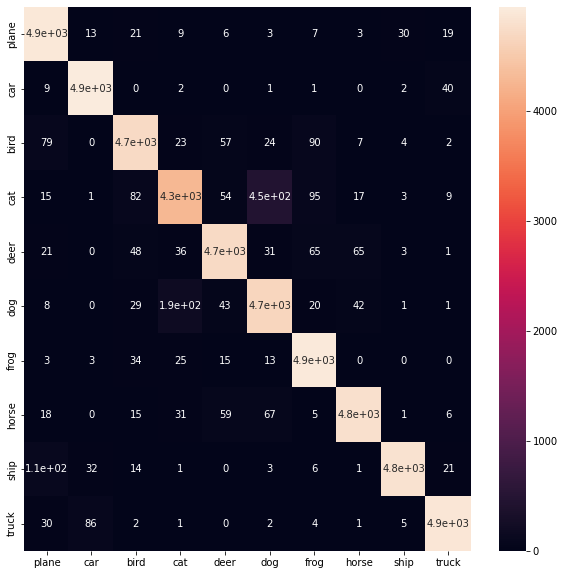

  0%|          | 0/21 [00:00<?, ?it/s]

Accuracy on valid is 0.9185999631881714


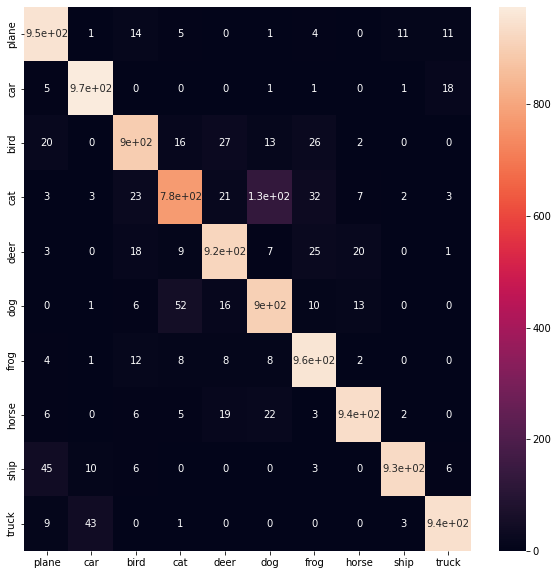

In [11]:
evaluation(best_model, loaders)

### Третьей была выбрана MobileNetV3 **large**

In [12]:
model = models.mobilenet_v3_large(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=960, out_features=128),
    nn.LeakyReLU(0.05),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=128, out_features=10),
)
freeze(model, freeze_layer)
optimizer = optim.AdamW(list(model.parameters())[freeze_layer:], lr=3e-4)

In [13]:
best_model = train(num_epochs, model, optimizer, criterion, loaders, device, accumulation=accumulation)
torch.save(best_model.state_dict(), './mobilenetV3_large.pth')

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  1/15	Train loss: 0.8781   accuracy: 0.701	Eval loss: 0.4163   accuracy: 0.860


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  2/15	Train loss: 0.3701   accuracy: 0.871	Eval loss: 0.2501   accuracy: 0.914


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  3/15	Train loss: 0.2788   accuracy: 0.904	Eval loss: 0.2139   accuracy: 0.925


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  4/15	Train loss: 0.2202   accuracy: 0.925	Eval loss: 0.2105   accuracy: 0.928


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  5/15	Train loss: 0.1854   accuracy: 0.936	Eval loss: 0.2181   accuracy: 0.929


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  6/15	Train loss: 0.1587   accuracy: 0.945	Eval loss: 0.1991   accuracy: 0.932
Best eval loss: 0.210493


  0%|          | 0/105 [00:00<?, ?it/s]

Accuracy on train is 0.9544000029563904


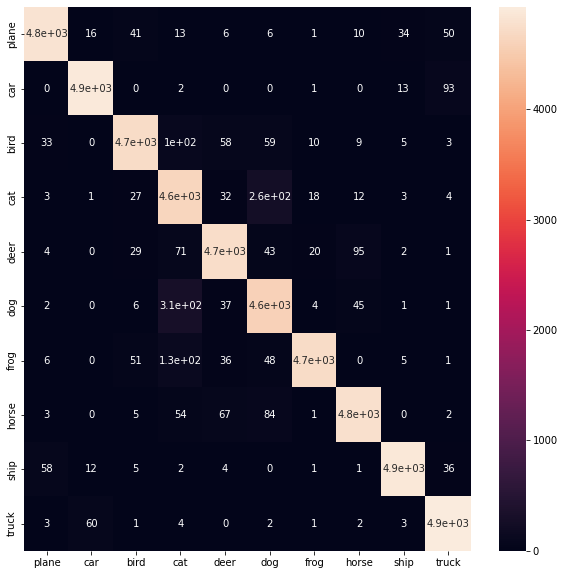

  0%|          | 0/21 [00:00<?, ?it/s]

Accuracy on valid is 0.927899956703186


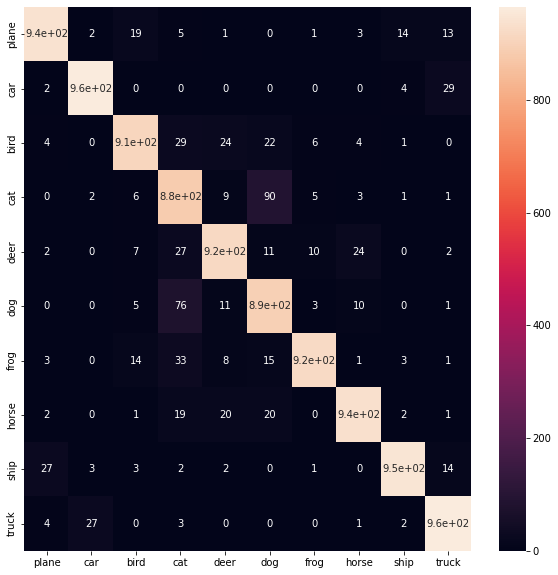

In [14]:
evaluation(best_model, loaders)

### Четвертый эксперимент - MobileNetV3 **large** с __FocalLoss__

In [15]:
def create_binary_label(classes: torch.Tensor) -> torch.Tensor:
    device = classes.device
    size = classes.size(0)
    labels = torch.zeros(size, 10, device=device)
    labels[torch.arange(size), classes] = 1
    return labels

In [16]:
class FocalLoss(nn.Module):
    """
    Focal loss from https://arxiv.org/pdf/1708.02002.pdf
    """
    def __init__(
            self,
            alpha: float = 0.25,
            gamma: float = 2,
            reduction: str = 'mean'
    ) -> None:
        """
        Method for init dataset
        Args:
            alpha: coefficient of loss
            gamma: coefficient of loss
            reduction: type of reduction None|'sum'|'mean'
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets) -> torch.Tensor:
        """
        Method for computing loss
        Args:
            inputs: logits from model
            targets: targets labels
        Returns:
            final value of computed loss
        """
        targets = create_binary_label(targets)
        p = torch.sigmoid(inputs)
        ce_loss = F.binary_cross_entropy_with_logits(
            inputs, targets, reduction="none"
        )
        p_t = p * targets + (1 - p) * (1 - targets)
        loss = ce_loss * ((1 - p_t) ** self.gamma)
        if self.alpha >= 0:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss = alpha_t * loss
        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()
        return loss

In [17]:
model = models.mobilenet_v3_large(pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=960, out_features=128),
    nn.LeakyReLU(0.05),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=128, out_features=10),
)
freeze(model, freeze_layer)
criterion = FocalLoss()
optimizer = optim.AdamW(list(model.parameters())[freeze_layer:], lr=3e-4)

In [18]:
best_model = train(num_epochs, model, optimizer, criterion, loaders, device, accumulation=accumulation)
torch.save(best_model.state_dict(), './mobilenetV3_large_FocalLoss.pth')

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  1/15	Train loss: 0.0232   accuracy: 0.564	Eval loss: 0.0095   accuracy: 0.827


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  2/15	Train loss: 0.0090   accuracy: 0.839	Eval loss: 0.0066   accuracy: 0.882


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  3/15	Train loss: 0.0067   accuracy: 0.884	Eval loss: 0.0057   accuracy: 0.897


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  4/15	Train loss: 0.0054   accuracy: 0.908	Eval loss: 0.0052   accuracy: 0.909


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  5/15	Train loss: 0.0046   accuracy: 0.923	Eval loss: 0.0047   accuracy: 0.920


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:  6/15	Train loss: 0.0039   accuracy: 0.936	Eval loss: 0.0045   accuracy: 0.926
Best eval loss: 0.005227


  0%|          | 0/105 [00:00<?, ?it/s]

Accuracy on train is 0.9358399510383606


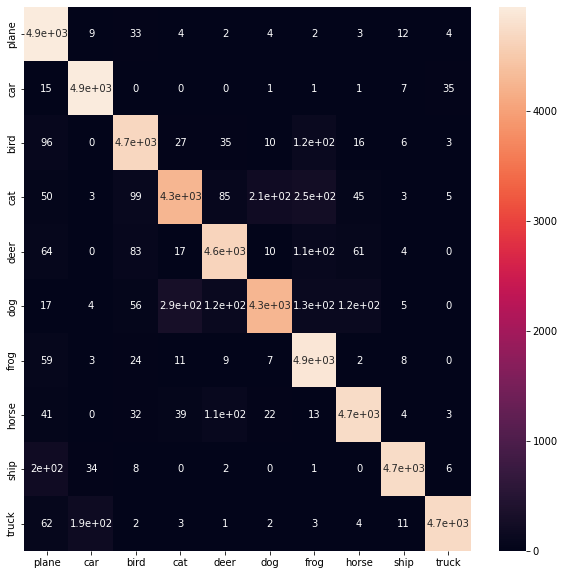

  0%|          | 0/21 [00:00<?, ?it/s]

Accuracy on valid is 0.9092999696731567


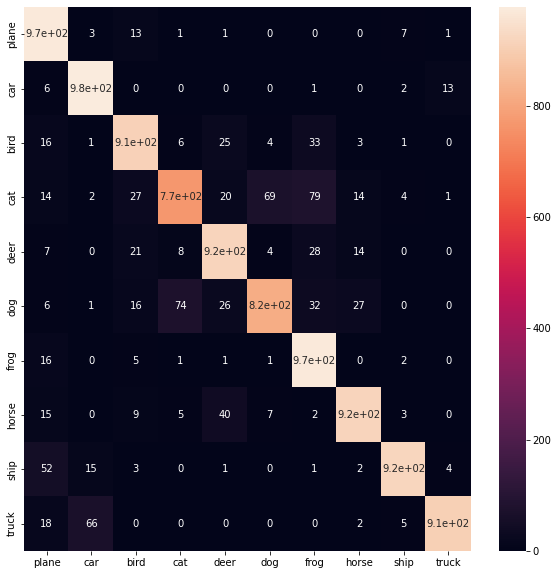

In [19]:
evaluation(best_model, loaders)